# Classification – Failure vs No-Failure 

Goal: build a classification model to predict whether a system failure occurs
based on operational and sensor-like features.

This notebook focuses on:
- Binary classification
- Model evaluation beyond accuracy
- Precision, recall, and confusion matrices

The problem setup mirrors predictive maintenance scenarios in aviation.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print('Ready')

Ready


In [16]:
df = pd.read_csv('/Users/mykael/ml-fundamentals/data/predictive_maintenance.csv')
df.head()
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [17]:
X = df.drop(columns=['UDI','Product ID','TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure'])
y = df['Machine failure']

X = pd.get_dummies(X, columns=["Type"], drop_first=True)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000) # using logistic regression cos its the most common for classification tasks(failure (0)or not
#failure (1))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


[0 0 0 ... 0 0 0]


In [28]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


'''
Confusion Matrix:
        pred 0   pred 1
 act 0 [ 1930       9]   
 act 1 [ 43       18]]

 Confusion Matrix:
 [TN  FP]
 [FN  TP]

  - True Negatives (TN): 1930 (correctly predicted no failure)
  - False Positives (FP): 9 (incorrectly predicted failure)
  - False Negatives (FN): 43 (missed failures)
  - True Positives (TP): 18 (correctly predicted failures)]


While accuracy is high(0.97) due to class imbalance, the model exhibits low recall(0.30) for failure events, 
indicating that many failures are missed. In predictive maintenance and aviation contexts, recall is more critical than 
accuracy, as false negatives pose higher operational risk. precison is also moderate(0.67), suggesting that when the model predicts a failure,
it is correct 67% of the time. Overall, the model needs improvement in recall to be effective for maintenance prediction.
'''


Accuracy: 0.974

Confusion Matrix:
 [[1930    9]
 [  43   18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.67      0.30      0.41        61

    accuracy                           0.97      2000
   macro avg       0.82      0.65      0.70      2000
weighted avg       0.97      0.97      0.97      2000



## Improving Failure Recall

To reduce missed failures, two strategies were applied:
1. Class weighting to penalize misclassification of failure events
2. Adjustment of the decision threshold using predicted probabilities

This shifts the model toward higher recall at the cost of additional false alarms,
which is acceptable in a maintenance context.


In [ ]:
# Probabilities for class 1 (failure) to increase recall
y_proba = clf.predict_proba(X_test)[:, 1] # get probabilities for the positive class (failure) meaning of
#[:, 1] is to select all rows (:) and only the second column (1) which contains the probabilities for class 1

threshold = 0.25
y_pred_threshold = (y_proba >= threshold).astype(int) # convert probabilities to binary predictions based on threshold

print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report:\n", classification_report(y_test, y_pred_threshold))


Threshold: 0.25
Accuracy: 0.97

Confusion Matrix:
 [[1907   32]
 [  28   33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1939
           1       0.51      0.54      0.52        61

    accuracy                           0.97      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.97      0.97      0.97      2000



In [ ]:
'''
thresholds = [0.5, 0.4, 0.3, 0.25, 0.2]

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    report = classification_report(y_test, y_pred_t, output_dict=True)

    recall_failure = report["1"]["recall"]
    precision_failure = report["1"]["precision"]

    print(f"Threshold: {t}")
    print("  Recall (failure):   ", round(recall_failure, 3))
    print("  Precision (failure):", round(precision_failure, 3))
    print("  Confusion matrix:\n", cm)
    print("-" * 40)
'''

Threshold: 0.5
  Recall (failure):    0.295
  Precision (failure): 0.667
  Confusion matrix:
 [[1930    9]
 [  43   18]]
----------------------------------------
Threshold: 0.4
  Recall (failure):    0.311
  Precision (failure): 0.594
  Confusion matrix:
 [[1926   13]
 [  42   19]]
----------------------------------------
Threshold: 0.3
  Recall (failure):    0.443
  Precision (failure): 0.529
  Confusion matrix:
 [[1915   24]
 [  34   27]]
----------------------------------------
Threshold: 0.25
  Recall (failure):    0.541
  Precision (failure): 0.508
  Confusion matrix:
 [[1907   32]
 [  28   33]]
----------------------------------------
Threshold: 0.2
  Recall (failure):    0.574
  Precision (failure): 0.422
  Confusion matrix:
 [[1891   48]
 [  26   35]]
----------------------------------------


In [38]:
#giving class weights to hightlight that missing a failure (false negative) is worse than a false alarm (false positive).

clf_bal = LogisticRegression(max_iter=1000, class_weight="balanced") #balanced because the dataset is imbalanced so it will give more weight to the minority class

clf_bal.fit(X_train, y_train)

y_proba_bal = clf_bal.predict_proba(X_test)[:, 1]
y_pred_bal = clf_bal.predict(X_test)

print("Accuracy (balanced):", accuracy_score(y_test, y_pred_bal))
print("\nConfusion Matrix (balanced):\n", confusion_matrix(y_test, y_pred_bal))
print("\nClassification Report (balanced):\n", classification_report(y_test, y_pred_bal))


Accuracy (balanced): 0.8175

Confusion Matrix (balanced):
 [[1583  356]
 [   9   52]]

Classification Report (balanced):
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1939
           1       0.13      0.85      0.22        61

    accuracy                           0.82      2000
   macro avg       0.56      0.83      0.56      2000
weighted avg       0.97      0.82      0.88      2000



In [46]:
threshold = 0.7
y_pred_bal_t = (y_proba_bal >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_bal_t))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_t))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_t))


Accuracy: 0.9105

Confusion Matrix:
 [[1777  162]
 [  17   44]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1939
           1       0.21      0.72      0.33        61

    accuracy                           0.91      2000
   macro avg       0.60      0.82      0.64      2000
weighted avg       0.97      0.91      0.93      2000



In [ ]:
#Changing classifier from logistic regression to random forest with class weights and thresholding

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

print("Accuracy (balanced):", accuracy_score(y_test,y_pred_rf))
print("\nConfusion Matrix (balanced):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (balanced):\n", classification_report(y_test, y_pred_rf))

Accuracy (balanced): 0.979

Confusion Matrix (balanced):
 [[1935    4]
 [  38   23]]

Classification Report (balanced):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.85      0.38      0.52        61

    accuracy                           0.98      2000
   macro avg       0.92      0.69      0.76      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
threshold = 0.24
y_pred_rf_t = (y_proba_rf >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_rf_t))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_t))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_t))

'''A Random Forest classifier with class weighting and a tuned decision threshold was selected as the final model. 
This configuration achieved a recall of 77% on failure events while maintaining a precision of 61%, significantly 
reducing missed failures compared to the linear baseline. False positives were considered an acceptable tradeoff in a
 safety-critical maintenance context.
'''


Accuracy: 0.978

Confusion Matrix:
 [[1909   30]
 [  14   47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1939
           1       0.61      0.77      0.68        61

    accuracy                           0.98      2000
   macro avg       0.80      0.88      0.83      2000
weighted avg       0.98      0.98      0.98      2000



## Conclusions and Limitations

This notebook demonstrates a complete classification pipeline for failure
prediction, from baseline modeling to recall-focused optimization.

While the Random Forest model significantly improves failure detection, some
failures remain difficult to predict due to overlapping sensor patterns and
inherent randomness in the data. Future work could explore anomaly detection
or temporal modeling approaches.


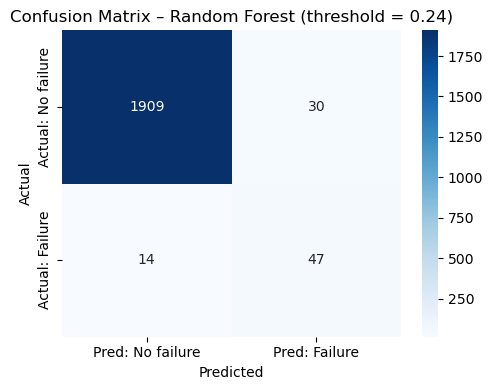

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf_t)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: No failure", "Pred: Failure"],
            yticklabels=["Actual: No failure", "Actual: Failure"])
plt.title("Confusion Matrix – Random Forest (threshold = 0.24)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


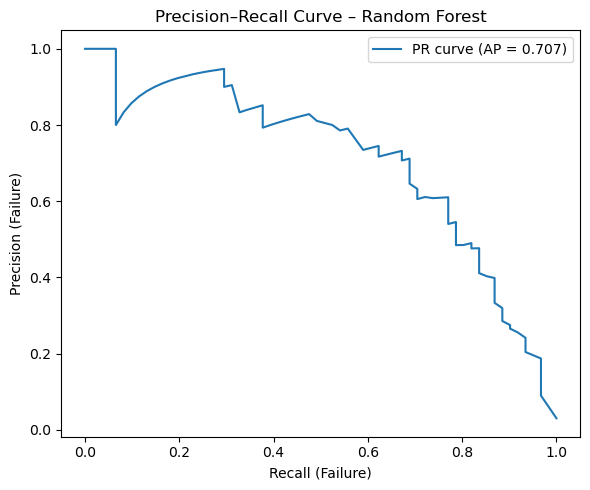

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

#The Precision–Recall curve shows the tradeoff between detecting more failures (higher recall) and limiting false alarms
#(higher precision). The selected threshold (0.24) corresponds to the region where recall is prioritized while retaining 
#acceptable precision.

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_rf)
ap = average_precision_score(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall (Failure)")
plt.ylabel("Precision (Failure)")
plt.title("Precision–Recall Curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


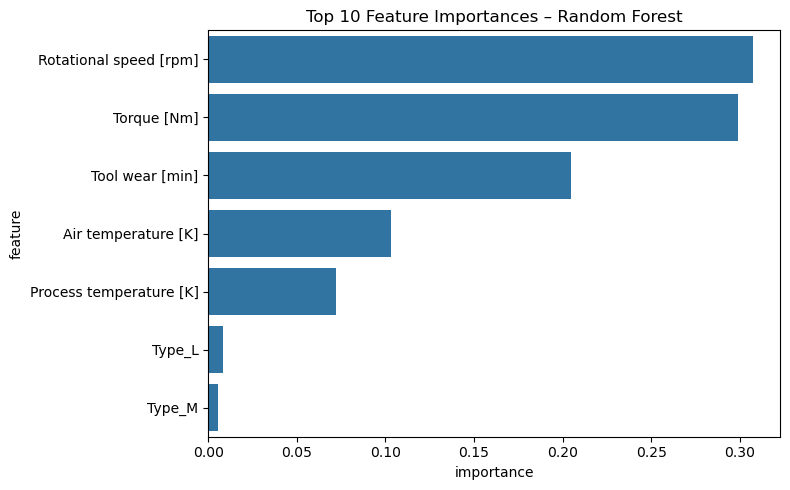

,feature,importance
2,Rotational speed [rpm],0.307361
3,Torque [Nm],0.298776
4,Tool wear [min],0.204752
0,Air temperature [K],0.103325
1,Process temperature [K],0.072053
5,Type_L,0.008227
6,Type_M,0.005506


In [ ]:
import numpy as np

#The feature importance plot indicates which operational and sensor variables
#contribute most to the model's failure predictions.


importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

feat_imp.head(10)
